In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import Adam

In [2]:
# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

### Pre-processing and selecting the metric

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0,1]
x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)  # Add channel dimension

### Train your initial model

In [4]:
def create_autoencoder(latent_dim=(4, 4, 32)):
    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(latent_dim[2], (3, 3), activation='relu', padding='same')(x)
    encoder_output = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(latent_dim[2], (3, 3), activation='relu', padding='same')(encoder_output)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Ensure the output dimensions match the input dimensions
    decoder_output = layers.Cropping2D(((2, 2), (2, 2)))(decoder_output)
    
    autoencoder = models.Model(encoder_input, decoder_output)
    return autoencoder

# Compile the model with Mean Squared Error loss
autoencoder = create_autoencoder()
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

# Print model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,777 (327.25 KB)

 Trainable params: 83,777 (327.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - loss: 0.0246 - val_loss: 0.0103
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 0.0082 - val_loss: 0.0074
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 0.0054 - val_loss: 0.0052


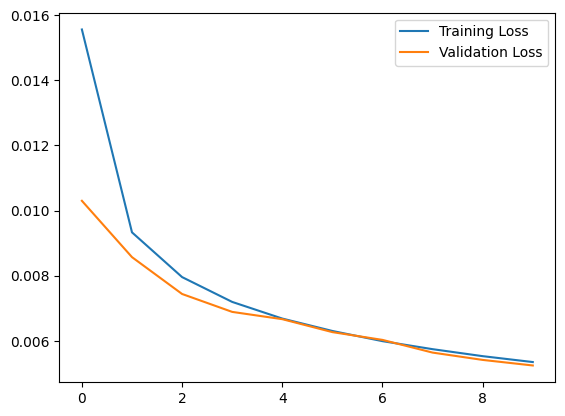

In [5]:
# Train the model
history = autoencoder.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Optimize your model

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 10/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.0044 - val_loss: 0.0045


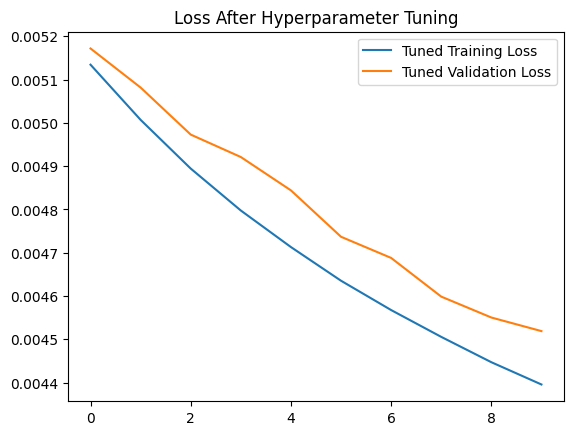

In [6]:
# Adjusted hyperparameters
learning_rate = 0.0005 # Default is 0.001
batch_size = 16 # Default is 32

# Recompile the model with the tuned learning rate
autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

# Retrain the model for another 10 epochs with the new batch size
history_tuned = autoencoder.fit(x_train, x_train, 
                                epochs=10, 
                                batch_size=batch_size, 
                                validation_data=(x_test, x_test))

# Plot the tuned model's training and validation loss
plt.plot(history_tuned.history['loss'], label='Tuned Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Tuned Validation Loss')
plt.legend()
plt.title("Loss After Hyperparameter Tuning")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


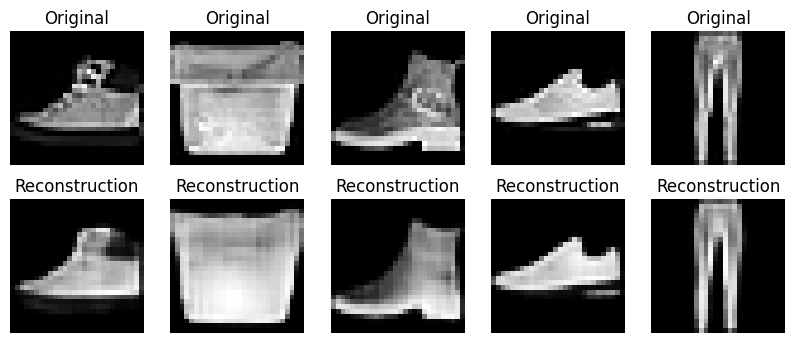

In [7]:
# Display some reconstructed images
def display_reconstructions(model, data, n=5):
    indices = random.sample(range(data.shape[0]), n)
    originals = data[indices]
    reconstructions = model.predict(originals)
    
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].squeeze(), cmap="gray")
        plt.title("Reconstruction")
        plt.axis("off")
    plt.show()

# Test and display reconstructed samples
display_reconstructions(autoencoder, x_test)

### Decrease the latent space


Training with latent space feature dimension: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


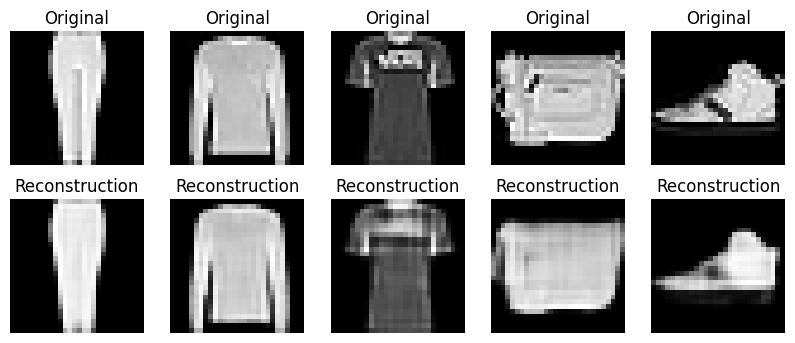


Training with latent space feature dimension: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


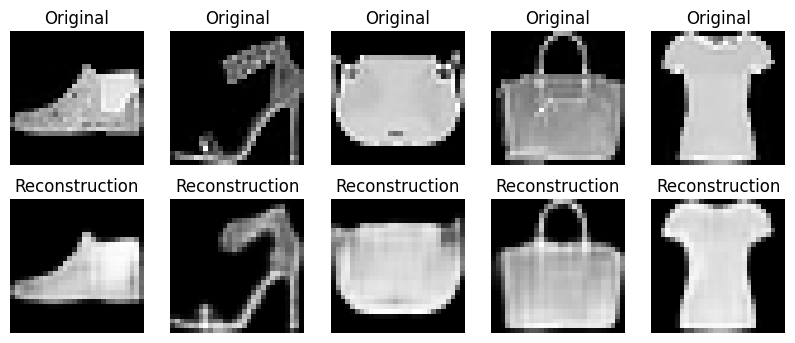


Training with latent space feature dimension: 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


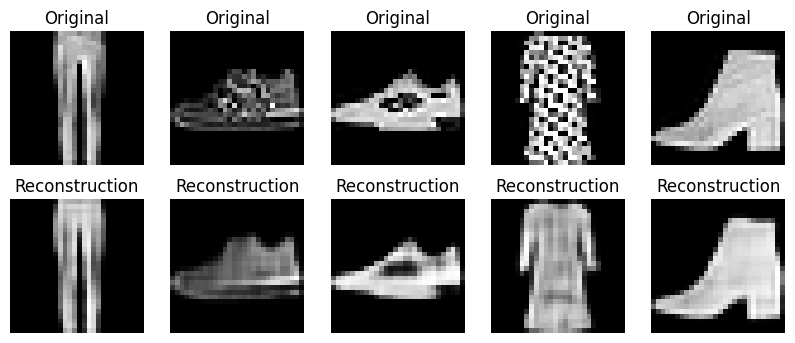


Training with latent space feature dimension: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


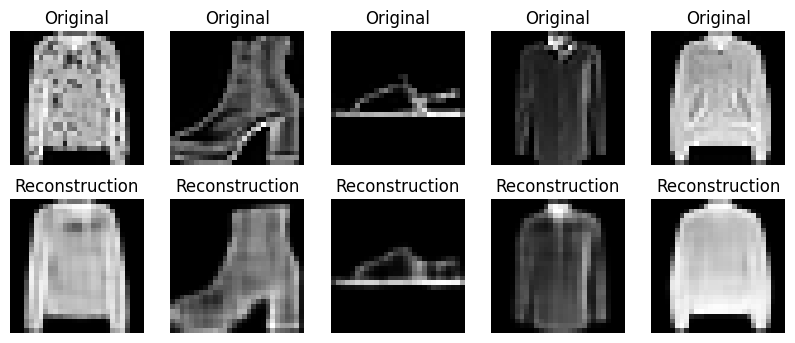


Training with latent space feature dimension: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


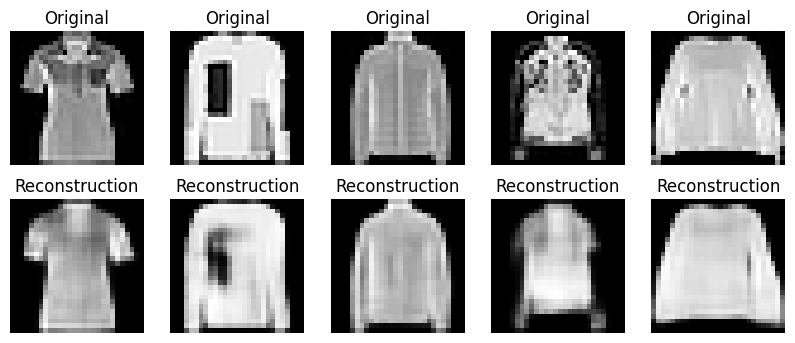


Training with latent space feature dimension: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


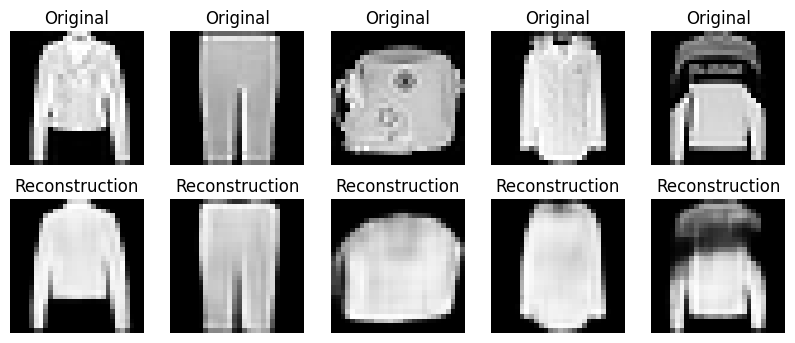


Training with latent space feature dimension: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


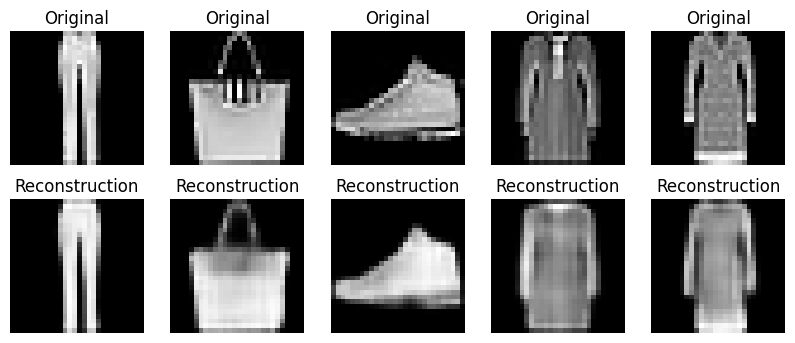

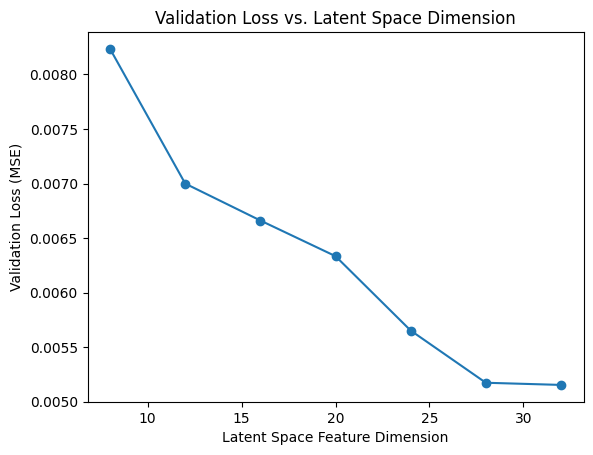

In [8]:
# Hyperparameters for adjusting
learning_rate = 0.0005 # Default is 0.001
batch_size = 16 # Default is 32

initial_latent_features = 32
latent_losses = []

# Decrease latent space by 4 each iteration and retrain model
for features in range(initial_latent_features, 4, -4):
    print(f"\nTraining with latent space feature dimension: {features}")
    autoencoder = create_autoencoder(latent_dim=(4, 4, features))
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    
    # Train and record validation performance
    history = autoencoder.fit(x_train, x_train, 
                              epochs=10, 
                              batch_size=batch_size, 
                              validation_data=(x_test, x_test), 
                              verbose=0)  # Set verbose to 0 to reduce output clutter
    
    # Append the last validation loss for this latent space size
    val_loss = history.history['val_loss'][-1]
    latent_losses.append((features, val_loss))

    # Display some reconstructions
    display_reconstructions(autoencoder, x_test, n=5)

# Plot the recorded validation losses
latent_dims, val_losses = zip(*latent_losses)
plt.plot(latent_dims, val_losses, marker='o')
plt.xlabel("Latent Space Feature Dimension")
plt.ylabel("Validation Loss (MSE)")
plt.title("Validation Loss vs. Latent Space Dimension")
plt.show()

### Final training


Training final model with optimal latent space dimension: 32
Epoch 1/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: 0.0236 - val_loss: 0.0102
Epoch 2/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 3/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 4/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 5/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 6/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 7/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 8/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 10/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 11/30
3750/3750 ━━━━━━━━━━━━━━━━━

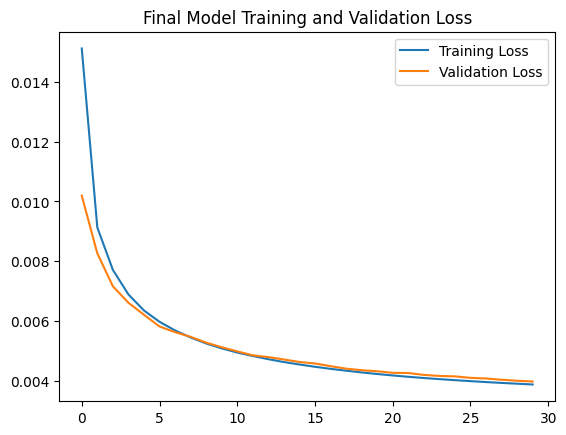

Model weights saved as 'optimal_autoencoder.weights.h5'


In [ ]:
optimal_latent_dim = min(latent_dims, key=lambda x: val_losses[latent_dims.index(x)] if val_losses[latent_dims.index(x)] < 0.1 else float('inf'))

# Rebuild and train the autoencoder with the optimal latent space dimension
print(f"\nTraining final model with optimal latent space dimension: {optimal_latent_dim}")

final_autoencoder = create_autoencoder(latent_dim=(4, 4, optimal_latent_dim))
final_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

# Train the model for 30 epochs on the full training set
history_final = final_autoencoder.fit(x_train, x_train, 
                                      epochs=30, 
                                      batch_size=batch_size, 
                                      validation_data=(x_test, x_test))

# Plot training and validation loss for the final model
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Final Model Training and Validation Loss")
plt.show()

# Save the final model weights
final_autoencoder.save_weights("model/optimal_autoencoder.weights.h5")
print("Model weights saved as 'model/optimal_autoencoder.weights.h5'")

### Testing the autoencoder

Final Model Reconstruction Error (MSE) on Test Dataset: 0.0040
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


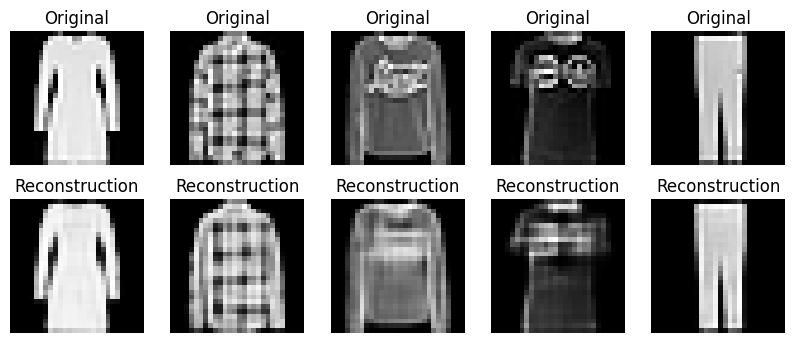

In [10]:
# Evaluate the final model on the test dataset to get the reconstruction error score
test_loss = final_autoencoder.evaluate(x_test, x_test, verbose=0)
print(f"Final Model Reconstruction Error (MSE) on Test Dataset: {test_loss:.4f}")

# Test the model on the test dataset and visualize reconstructions
display_reconstructions(final_autoencoder, x_test, n=5)